# Main Quest 01

캐글의 chest X-ray image로 폐렴 판별하기

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 20

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# val 개수 증가
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
# 정상 이미지, 폐렴 이미지 확인
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [7]:
# mini batch로 작업하기 위해 tf.data 인스턴스 생성
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


## data argumentation
이미지 회전, 가우시안 노이즈 추가 방법 

In [15]:
# data argumentation
def augment(image_batch,label_batch):
    # 좌우반전
    image = tf.image.random_flip_left_right(image_batch)  # 랜덤하게 좌우를 반전합니다.
    # 확대 또는 축소
    #image_batch = tf.image.random_zoom(image_batch, (0.8, 1.2))
    # 밝기 조정
    image_batch = tf.image.random_brightness(image_batch, max_delta=0.1)
    # 채도 조정
    image_batch = tf.image.random_saturation(image_batch, lower=0.8, upper=1.2)

    return image_batch,label_batch

BATCH_SIZE = 16
def prepare_for_training(ds, shuffle_buffer_size=1000, batch_size=BATCH_SIZE):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds, shuffle_buffer_size=1000)
val_ds = prepare_for_training(val_ds)

## 데이터 시각화

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

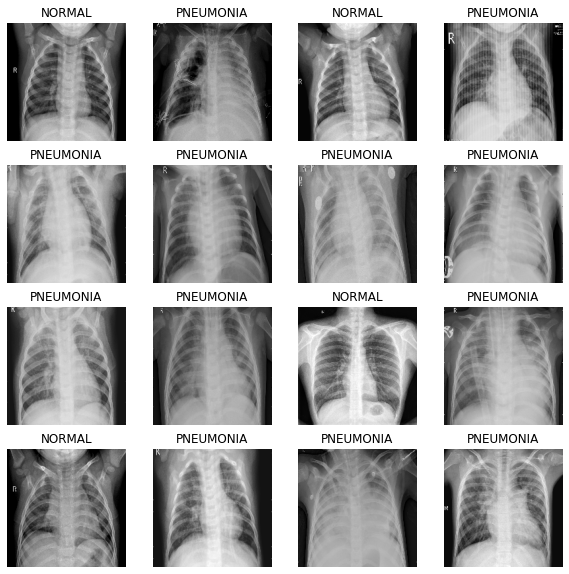

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())


In [17]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

## 모델링

In [18]:
import tensorflow as tf

# ResNet 18 모델을 빌드하는 함수
def build_resnet18(input_shape=(180, 180, 3)):
    input_tensor = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(64, 7, strides=(2, 2), padding='same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = residual_block(64)(x)
    x = residual_block(64)(x)

    x = residual_block(128, downsample=True)(x)
    x = residual_block(128)(x)

    x = residual_block(256, downsample=True)(x)
    x = residual_block(256)(x)

    x = residual_block(512, downsample=True)(x)
    x = residual_block(512)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.7)(x)

    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=output)

    return model

# residual_block 함수를 재정의
def residual_block(filters, downsample=False):
    strides = (2, 2) if downsample else (1, 1)

    def layer_function(input_tensor):
        x = tf.keras.layers.Conv2D(filters, 3, strides=strides, padding='same')(input_tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)

        if downsample:
            input_tensor = tf.keras.layers.Conv2D(filters, 1, strides=strides, padding='same')(input_tensor)
            x = tf.keras.layers.add([x, input_tensor])
        else:
            x = tf.keras.layers.add([x, input_tensor])

        x = tf.keras.layers.Activation('relu')(x)
        return x

    return layer_function

# ResNet 18 모델 빌드
model = build_resnet18()


In [20]:
# imbalnce 처리
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [21]:

# 모델 훈련
with tf.device('/GPU:0'):
    model = build_resnet18()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:

# 데이터셋의 입력 형태 (높이, 너비, 채널)
input_shape = (180, 180, 3)

# ResNet 18 모델 빌드
#model = build_resnet18(input_shape)

# 데이터셋을 준비하고 훈련 시작
#train_ds = prepare_for_training(train_ds, shuffle_buffer_size=1000)
#val_ds = prepare_for_training(val_ds)

# EarlyStopping 콜백 정의
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    # 감시할 지표 설정 (여기서는 검증 손실)
    patience=5,            # 지정된 지표가 개선되지 않더라도 몇 에폭까지 기다릴지 설정
    mode='min',            # 지표 개선을 위해 최소화를 기준으로 설정
    restore_best_weights=True)
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[early_stopping_callback]
    )

Epoch 1/20
261/261 [==============================] - 67s 204ms/step - loss: 0.5136 - accuracy: 0.7751 - precision: 0.9202 - recall: 0.7642 - val_loss: 7.7600 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 53s 202ms/step - loss: 0.3233 - accuracy: 0.8640 - precision: 0.9649 - recall: 0.8481 - val_loss: 2.0854 - val_accuracy: 0.7981 - val_precision: 0.7844 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 53s 205ms/step - loss: 0.2551 - accuracy: 0.8942 - precision: 0.9757 - recall: 0.8795 - val_loss: 1.5733 - val_accuracy: 0.4538 - val_precision: 0.9899 - val_recall: 0.2572
Epoch 4/20
261/261 [==============================] - 54s 207ms/step - loss: 0.2441 - accuracy: 0.9083 - precision: 0.9776 - recall: 0.8975 - val_loss: 0.1672 - val_accuracy: 0.9173 - val_precision: 0.9788 - val_recall: 0.9069
Epoch 5/20
261/261 [==============================] - 55s 212ms/step - loss: 0.1847 - accura

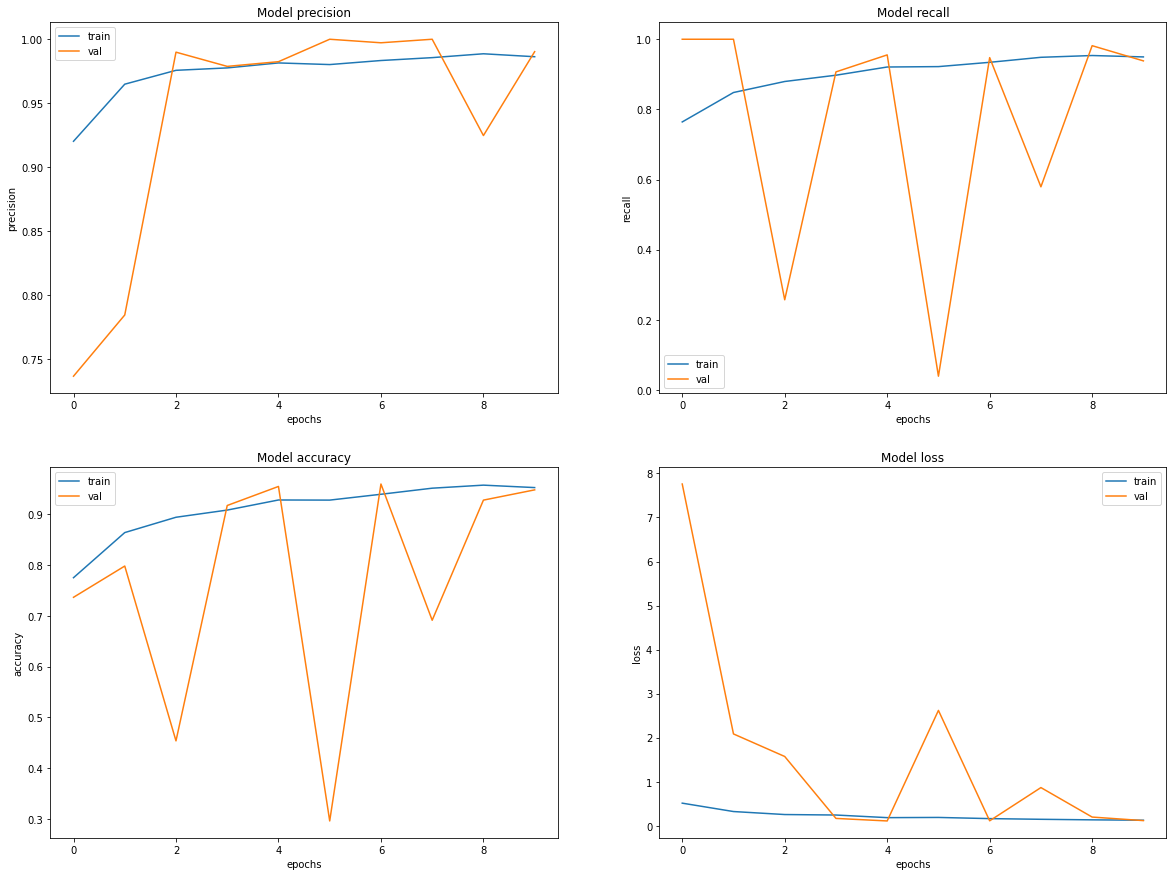

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 119ms/step - loss: 0.7916 - accuracy: 0.8125 - precision: 0.7803 - recall: 0.9744
Loss: 0.7916427254676819,
Accuracy: 0.8125,
Precision: 0.7802874445915222,
Recall: 0.9743589758872986
